In [1]:
import numpy as np
import pandas as pd
from darts.timeseries import TimeSeries
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
from copy import deepcopy

In [2]:
target_scaler = Scaler()
cov_scaler = Scaler()

In [3]:
raw_data = pd.read_csv('s3://darts-timeseries/processed_data.csv', parse_dates=['date'])

In [4]:
raw_data.columns

Index(['date', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5',
       'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out',
       'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv2',
       'total_load'],
      dtype='object')

In [5]:
time_col = 'date'
value_cols = list(raw_data.columns)
value_cols.pop(value_cols.index(time_col))

'date'

In [6]:
cov_cols = deepcopy(value_cols)
cov_cols.pop(cov_cols.index('total_load'))

'total_load'

In [7]:
ts_data = TimeSeries.from_dataframe(raw_data, time_col=time_col, value_cols=value_cols)

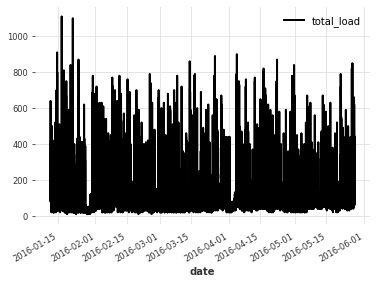

In [8]:
ts_data['total_load'].plot()

In [9]:
train, test = ts_data.split_after(0.8)

In [10]:
train_target = target_scaler.fit_transform(train['total_load'])
train_cov = cov_scaler.fit_transform(train[cov_cols])

In [11]:
test_target = target_scaler.transform(test['total_load'])
test_cov = cov_scaler.transform(test[cov_cols])

In [12]:
lstm_model = RNNModel(
    model='LSTM',
    input_chunk_length=24*6*7*2,
    output_chunk_length=24*6,
    training_length=24*6*7*5,
    dropout=0.1,
    hidden_dim=30,
    n_rnn_layers=4,
    n_epochs=100,
    batch_size=256
)

In [ ]:
lstm_model.fit(train_target, future_covariates=train_cov.append(test_cov), verbose=True)

[2021-12-02 22:56:39,384] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 10748 samples.
[2021-12-02 22:56:39,384] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 10748 samples.
[2021-12-02 22:56:40,104] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-02 22:56:40,104] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
ts_data